# About
This Jupyter notebook contains code for extracting dialogue from different games. To do this, the code will:
* Look for a file within the working directory (the directory in which this Jupyter notebook resides)
* Extract dialogue from the file using regular expressions
* Clean the dialogue to remove extraneous characters, spaces, and punctuation
* Convert that data into a dataframe where speakers make up one column and lines make up another column
* Create different visualizations based on the contents of that data

Additionally, the notebook contains code for saving cleaned dialogues and dataframes (in the event that we need to redo some of our steps).

# Step 1: Extracting the Data
Assume that the contents of the transcripts have been copied and pasted into `.txt` files that stored within the current **working directory**.
The working directory is the folder that contains this Jupyter notebook. For example:
```
is-278-resident-evil-data-viz/
├── RE0-data / <-- This is the working directory
|   ├── RE0_Data_Setup.ipynb 
|   └── RE0_Transcript.txt
```
While we could scrape websites for transcripts, some of the websites we're referencing for this project are known to block web-crawling attempts, despite the robots.txt files suggesting otherwise.<br>
Once we set up the project, we can start thinking about cleaning the data.<br>
Opening and reading the contents of the `.txt` files requires us to know the locations of the files. We can retrieve this information with the `os` module.

In [2]:
import os # Allows us to retrieve file paths

def get_path_to_file(file: str) -> str:
    ''' Returns the path to a file in a working directory.
        Note that function will still return a path even if the file
        doesn't exist in that directory.'''
    return os.path.realpath(file)

We know from skimming the transcripts that all dialogue comes in the format `SPEAKER: LINE`, where `SPEAKER` is the name of a character (i.e. "Barry") and `LINE` is the character's dialogue (i.e. "That was too close. You were almost a Jill sandwich."). Based on this pattern, we can create a **regular expression (regex)** and the `re` module to find and capture lines in this format.<br>
Our regex is `^[A-Z]{1}[A-Za-z '.]+:{1}(.+[\n|\r\n|\r])*`. It'll match any line with the following characteristics:
* The first part of the sentence must contain a word that begins with a capital letter and is followed by one or more letters, spaces, or apostrophes
* The second part of the sentence must contain a character followed by a newline character
* Both parts of the sentence must be separated by exactly one colon

As an unintended consequence, this method will also capture lines that are formatted like dialogue but are not actually lines of dialogue. For example, the line "To: Emily" will be captured by the regex, even though it represents an email header. But such mistakes can be removed during the cleaning process.

To save time, we're going to pre-emptively perform some data cleaning during the data extraction phase. If we find any lines that match the `SPEAKER: LINE` format, we're going to:
* Remove extraneous newline characters and spaces
* Remove extraneous punctuation (i.e. quotation marks around dialogue that have been added in by transcribers for stylistic reasons)
* Standardize character names such that every part of the name is capitalized (i.e. "JILL" becomes "Jill" and "Woman in red" becomes "Woman in Red")

In [4]:
import re # Allows us to identify patterns in lines

# Helper functions for identifying speakers and their lines of dialogue
def get_speaker(line: str) -> str:
    ''' Returns the name of the pe}rson who spoke a line of dialogue. '''
    return line[:line.find(':')].strip()

def get_speech(line: str) -> str:
    ''' Returns a line of dialogue. '''
    return line[line.find(':') + 2:].strip() # (+2) to skip the colon and space

def replace_newline_characters(line: str) -> str:
    ''' Replaces all the newline characters with spaces. '''
    return line.replace('\n', ' ').replace('\r\n', ' ').replace('\r', ' ')

def replace_typewriter_space(line: str) -> str:
    ''' Replaces two spaces with a single space. '''
    return line.replace('  ', ' ')

def replace_quotation_marks(line: str) -> str:
    ''' Removes quotation marks. '''
    return line.replace('"', '')

def capitalize_speaker(line: str) -> str:
    ''' Standardizes speaker name formats by capitalizing names. '''
    return get_speaker(line).title() + ': ' + get_speech(line) + '\n'

def get_cleaned_line(line: str) -> str:
    ''' Standardizes the formatting of a line by removing extraneous characters
        and capitalizing speaker names. '''
    line = replace_newline_characters(line)
    line = replace_typewriter_space(line)
    line = replace_quotation_marks(line)
    line = capitalize_speaker(line)
    return line 

def get_dialogue(input: str) -> list:
    ''' Returns a list of lines representing direct game dialogue
        from a transcript. '''
    dialouge = []
    with open(input, 'r', encoding = 'utf-8') as file: # UTF-8-SIG = UTF-8 BOM
        for line in re.finditer("^[A-Z]{1}[A-Za-z '.]+:{1}(.+[\n|\r\n|\r])*", file.read(), re.MULTILINE):
            line = get_cleaned_line(line.group(0))
            if (len(line[line.find(':') + 2:]) == 1): # Skip empty lines
                continue
            dialouge.append(line)
    return dialouge

Once we've extracted the dialogue, we can convert our data into a `.txt` file, which we can then manually check for errors.

In [122]:
def save_dialogue(output: str, dialogue: list) -> None:
    ''' Saves extracted dialogue to a new .txt file. If a file with the same name exists, 
        in the current working directory, that file will be replaced. '''
    with open(output, 'w', encoding = 'utf-8') as file:
        for line in dialogue:
            file.write(line)

def extract_dialogue(input: str, output: str) -> None:
    ''' Extracts dialogue from a transcript and saves that dialogue to a new .csv file. '''
    save_dialogue(output, get_dialogue(input))

extract_dialogue(get_path_to_file('RE0_Transcript.txt'), get_path_to_file('RE0_Extracted_Transcript.txt'))

## Step 2: Validating the Data
After extracting the data, we can open the new `.txt` file, skim the contents, and fix errors that were not caught during our pre-emptive data cleaning phase.<br>
This is the point where we try to add in missing dialogue and correct obvious errors (such as improperly separated lines). We can also cross-reference the extracted data against other data sources to increase the accuracy and completeness of our dataset.
For *Resident Evil 0*, I cross-referenced the extracted transcript against the [*Resident Evil Wiki*'s transcripts](https://residentevil.fandom.com/wiki/Template:Resident_Evil_0_cutscenes).

## Step 3: Cleaning the Data
We can now convert the contents of our processed `.txt` file into a `pandas.DataFrame` and reorganize the data. This requires us to install and import `pandas`.

In [22]:
import pandas # Allows us to create and manipulate DataFrames

def get_dataframe(input: str) -> pandas.DataFrame:
    ''' Creates a dataframe from a processed transcript. '''
    data = []
    with open(input, 'r', encoding = 'utf-8') as file:
        for line in file:
            data.append([get_speaker(line), get_speech(line)]) # Pandas accepts a list of lists as an argument
    return pandas.DataFrame(data, columns = ['Character', 'Line'])

re0_data = get_dataframe(get_path_to_file('RE0_Extracted_Transcript.txt'))
re0_data

,Character,Line
0,Narrator's Voice,A small mid-western town in America: Raccoon C...
1,Man,Really?
2,Woman,"Hmm, do you think so too?"
3,Bald Man,Yeah.
4,White Man,.do about it?
...,...,...
228,Billy,"Rebecca, hurry!"
229,Rebecca,Hey that must be the old mansion Enrico was ta...
230,Rebecca,"I guess it's time to say goodbye. Officially, ..."
231,Billy,"Yeah, I'm just a zombie now."


One change we might want to do is standardizing names within the dataset. If you've looked through the *Resident Evil 0* transcript, you might have noticed that characters sometimes are referenced with different aliases. The character, Rebecca, for instance, has lines under the alias `Rebecca` and `Rebecca's Voice`. It would easier to do data analysis if all the lines were grouped under the name `Rebecca`.<br>
We can see all the characters contained within the current dataset by calling the `unique()` function on the `Character` column.

In [23]:
re0_data['Character'].unique()

array(["Narrator's Voice", 'Man', 'Woman', 'Bald Man', 'White Man',
       'Black Man', 'Man With Glasses', "Rebecca's Voice", 'Enrico',
       'Edward', 'Rebecca', 'Billy', 'Soldier', 'Wesker', 'Birkin',
       'Marcus', 'Queen Leech', 'Commander', 'Computer', 'Computer Voice'],
      dtype=object)

We can then quickly replace related character names using a dictionary.

In [24]:
aliases = {"Computer Voice": "Computer",
           "Narrator's Voice": "Narrator",
           "Rebecca's Voice": "Rebecca"}

re0_data['Character'] = re0_data['Character'].replace(aliases)
re0_data['Character'].unique()

array(['Narrator', 'Man', 'Woman', 'Bald Man', 'White Man', 'Black Man',
       'Man With Glasses', 'Rebecca', 'Enrico', 'Edward', 'Billy',
       'Soldier', 'Wesker', 'Birkin', 'Marcus', 'Queen Leech',
       'Commander', 'Computer'], dtype=object)

Because we are also interested in tracking gender representation, we may also want to assign each character a gender.

In [25]:
re0_genders = {'Narrator': pandas.NA,
           'Man': 'Male',
           'Woman': 'Female',
           'Bald Man': 'Male',
           'White Man': 'Male',
           'Man With Glasses': 'Male',
           'Rebecca': 'Female',
           'Enrico': 'Male',
           'Edward': 'Male',
           'Billy': 'Male',
           'Soldier': pandas.NA,
           'Wesker': 'Male',
           'Birkin': 'Male',
           'Marcus': 'Male',
           'Queen Leech': pandas.NA, # The Wiki calls Queen Leech an it (animal / monster)
           'Commander': pandas.NA, 
           'Computer': pandas.NA}

re0_data['Gender'] = re0_data['Character'].map(re0_genders)
re0_data.insert(1, 'Gender', re0_data.pop('Gender')) # Shift the order of columns
re0_data

,Character,Gender,Line
0,Narrator,<NA>,A small mid-western town in America: Raccoon C...
1,Man,Male,Really?
2,Woman,Female,"Hmm, do you think so too?"
3,Bald Man,Male,Yeah.
4,White Man,Male,.do about it?
...,...,...,...
228,Billy,Male,"Rebecca, hurry!"
229,Rebecca,Female,Hey that must be the old mansion Enrico was ta...
230,Rebecca,Female,"I guess it's time to say goodbye. Officially, ..."
231,Billy,Male,"Yeah, I'm just a zombie now."


We can save our data to a `.csv` file using `pandas`.

In [26]:
re0_data.to_csv(get_path_to_file('RE0_Data.csv'), encoding = 'utf-8', index = False)

# Step 4: Analyzing the Data
We can now attempt to explore the dataset using `matplotlib`.

In [9]:
import matplotlib.pyplot as plt # Needed to create data visualizations

Here are some questions we can ask and answer using our dataset.
## Question 1: How many times do female characters speak compared to male characters?

In [28]:
# Count the frequencies of each gender within the dataset
re0_gender_counts = re0_data['Gender'].value_counts()
re0_gender_counts

Gender
Male      124
Female     93
Name: count, dtype: int64

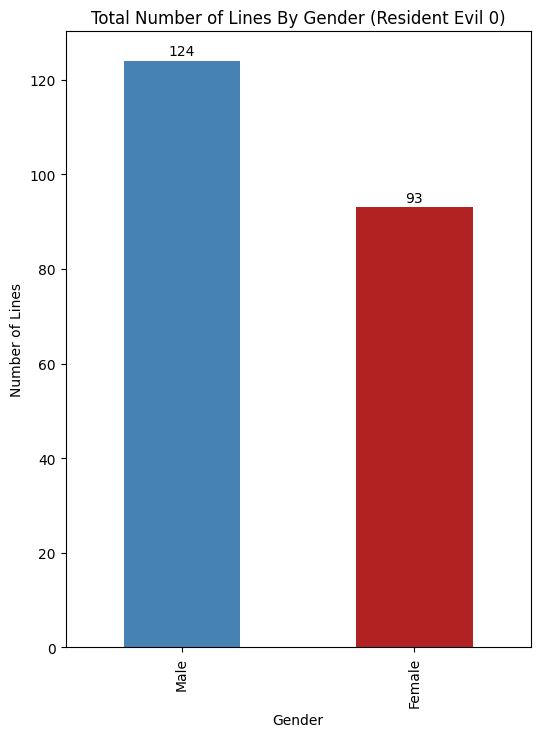

In [29]:
# Create the visualization (in this case, a bar chart)
plt.figure(figsize = (6, 8))
plt.title('Total Number of Lines By Gender (Resident Evil 0)')
plt.xlabel('Gender')
plt.ylabel('Number of Lines')

# Plot the data
ax = re0_gender_counts.plot(kind = 'bar', color = ['SteelBlue', 'FireBrick', 'LightGray', 'LightGray'])
# Add labels for clarity
for patch in ax.patches:
    ax.annotate(f'{patch.get_height()}', (patch.get_x() + patch.get_width() / 2, patch.get_height() + 2),
                    ha = 'center', va = 'center')
plt.show()

### Question 2: How long do female characters speak compared to male characters?
In order to answer this question, we need to remove emotes and actions (i.e. (gasps)) from the dialogue. We can achieve this using another regex. The regex we're using is `\(.*\)`, which will capture any characters contained within a set of parentheses (as well the parentheses themselves).

In [30]:
import re

def remove_stage_directions(line: str) -> str:
    ''' Removes stage directions 
        (phrases contained within parentheses). '''
    return re.sub("\(.*\)", '', line)

# Remove stage directions from the dataset
re0_data['Line'] = re0_data['Line'].apply(remove_stage_directions)
re0_data

,Character,Gender,Line
0,Narrator,<NA>,A small mid-western town in America: Raccoon C...
1,Man,Male,Really?
2,Woman,Female,"Hmm, do you think so too?"
3,Bald Man,Male,Yeah.
4,White Man,Male,.do about it?
...,...,...,...
228,Billy,Male,"Rebecca, hurry!"
229,Rebecca,Female,Hey that must be the old mansion Enrico was ta...
230,Rebecca,Female,"I guess it's time to say goodbye. Officially, ..."
231,Billy,Male,"Yeah, I'm just a zombie now."


In [31]:
# Count the number of words in each character's dialogue
re0_data['Words'] = re0_data['Line'].apply(lambda x: len(x.split(' ')))
re0_data

,Character,Gender,Line,Words
0,Narrator,<NA>,A small mid-western town in America: Raccoon C...,100
1,Man,Male,Really?,1
2,Woman,Female,"Hmm, do you think so too?",6
3,Bald Man,Male,Yeah.,1
4,White Man,Male,.do about it?,3
...,...,...,...,...
228,Billy,Male,"Rebecca, hurry!",2
229,Rebecca,Female,Hey that must be the old mansion Enrico was ta...,11
230,Rebecca,Female,"I guess it's time to say goodbye. Officially, ...",13
231,Billy,Male,"Yeah, I'm just a zombie now.",6


In [32]:
average_word_count = round(re0_data.groupby('Gender')['Words'].mean(), 2)
average_word_count.dropna()
average_word_count = average_word_count.sort_values(ascending = False)
average_word_count

Gender
Male      9.65
Female    6.55
Name: Words, dtype: float64

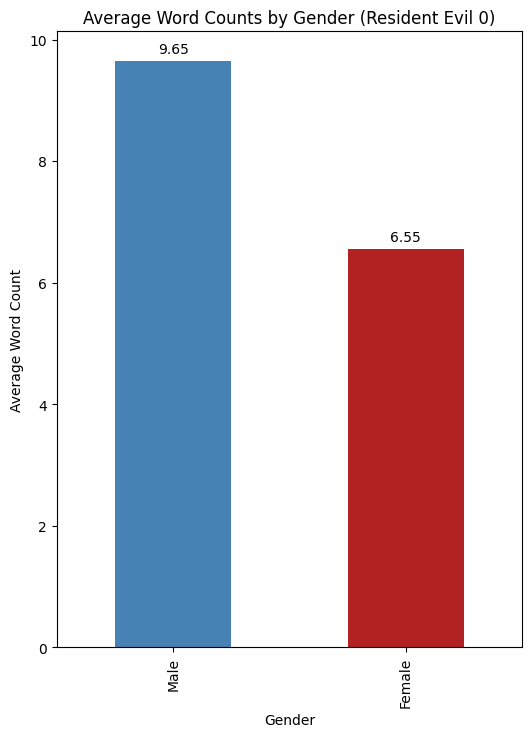

In [34]:
# Create the visualization (another bar chart)
plt.figure(figsize = (6, 8))
plt.title('Average Word Counts by Gender (Resident Evil 0)')
plt.xlabel('Gender')
plt.ylabel('Average Word Count')

# Plot the data
ax = average_word_count.plot(kind = 'bar', color = ['SteelBlue', 'FireBrick'])
# Add labels for clarity
for patch in ax.patches:
    ax.annotate(f'{patch.get_height()}', (patch.get_x() + patch.get_width() / 2, patch.get_height() + 0.2),
                    ha = 'center', va = 'center')
plt.show()